In [2]:
pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install statsmodels


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -----------------------------

In [9]:
pip install keras

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   ------- -----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [13]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


# Predictive Modeling


Linear Regression Evaluation:
MAE: 10982.34
RMSE: 21502.68
MAPE: 25.04


c:\Users\umerc\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\umerc\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\umerc\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\umerc\AppData\Local\Programs\Python\Python313\Lib


ARIMA Forecast (next 24 hours): [5351.77179102 5390.42522995 5404.64903694 5401.96488183 5387.31452122
 5376.5773843  5379.59497502 5381.44025176 5383.03254474 5383.6638191
 5383.29169875 5382.79029193 5382.70313024 5382.71025201 5382.77836265
 5382.83144425 5382.83723418 5382.82282742 5382.81409533 5382.81006251
 5382.81101879 5382.81337728 5382.8144852  5382.81446635]
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuned Random Forest Evaluation:
MAE: 11531.18
RMSE: 22190.27
MAPE: 28.40
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuned XGBoost Evaluation:
MAE: 11162.55
RMSE: 21733.06
MAPE: 26.23

Tuned Ensemble Evaluation:
MAE: 11329.02
RMSE: 21925.70
MAPE: 27.31


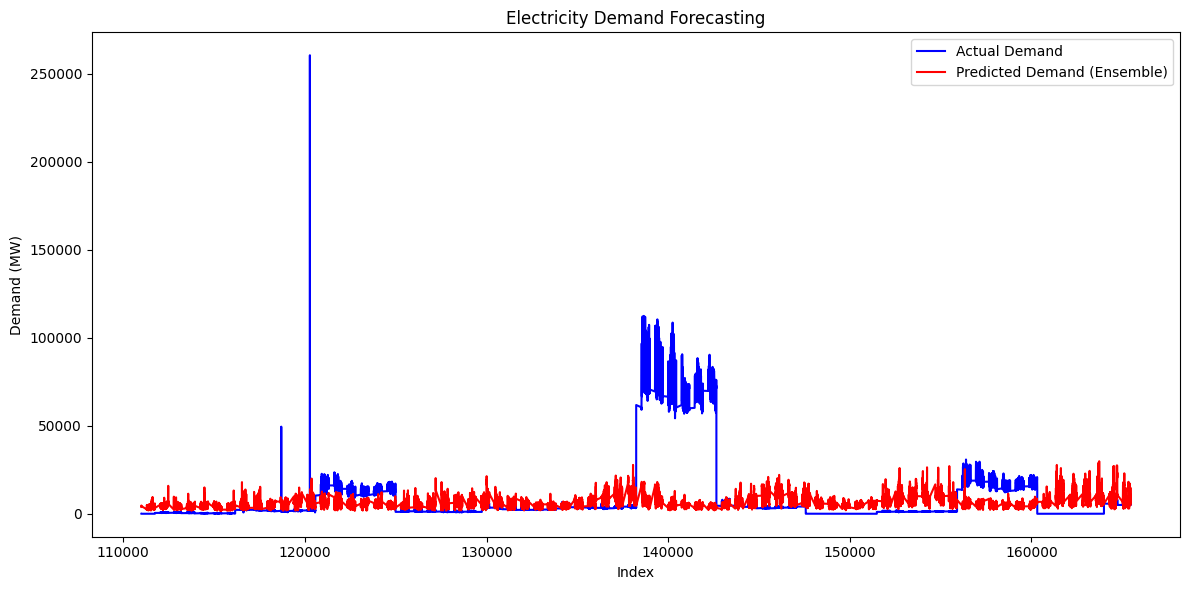

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv('whole_merged_data.csv', low_memory=False)
df = df.iloc[:165741]  # Use only up to specified row

# Clean column names and convert datetime
df.columns = df.columns.str.strip()
df['Data Date'] = pd.to_datetime(df['Data Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Data Date')

# Add temporal features
df['Day'] = df['Data Date'].dt.day
df['Month'] = df['Data Date'].dt.month
df['Weekday'] = df['Data Date'].dt.weekday

# Clean and rename demand column
if 'Demand (MW)' in df.columns:
    df.rename(columns={'Demand (MW)': 'Demand'}, inplace=True)
df['Demand'] = df['Demand'].replace({',': ''}, regex=True)
df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
df.dropna(subset=['Demand'], inplace=True)

# Define features and target
features = ['precipIntensity', 'precipProbability', 'temperature', 'humidity', 
            'pressure', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'Day', 'Month', 'Weekday']
df['Next_Demand'] = df['Demand'].shift(-1)
df.dropna(subset=['Next_Demand'], inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

# Split data
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
X_train = train[features]
y_train = train['Next_Demand']
X_test = test[features]
y_test = test['Next_Demand']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("\nLinear Regression Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_lr):.2f}")

# --- ARIMA ---
arima_series = df['Next_Demand']
arima_model = ARIMA(arima_series, order=(5, 1, 0))
arima_fitted = arima_model.fit()
arima_forecast = arima_fitted.forecast(steps=24)
print("\nARIMA Forecast (next 24 hours):", arima_forecast.values)

# --- Grid Search for Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, 
                       cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nTuned Random Forest Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf):.2f}")

# --- Grid Search for XGBoost ---
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1]
}
xgb_grid = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42),
                        xgb_param_grid, cv=3, scoring='neg_mean_absolute_error',
                        n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
print("\nTuned XGBoost Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_xgb):.2f}")

# --- Ensemble with Tuned Models ---
ensemble_model = VotingRegressor(estimators=[('rf', best_rf), ('xgb', best_xgb)])
ensemble_model.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
print("\nTuned Ensemble Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_ensemble):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ensemble)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_ensemble):.2f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Demand', color='blue')
plt.plot(y_test.index, y_pred_ensemble, label='Predicted Demand (Ensemble)', color='red')
plt.xlabel('Index')
plt.ylabel('Demand (MW)')
plt.title('Electricity Demand Forecasting')
plt.legend()
plt.tight_layout()
plt.show()



Bagging (Random Forest) Evaluation:
MAE: 12285.25
RMSE: 22607.87
MAPE: 34.43

Boosting (AdaBoost) Evaluation:
MAE: 14318.37
RMSE: 21377.84
MAPE: 49.60


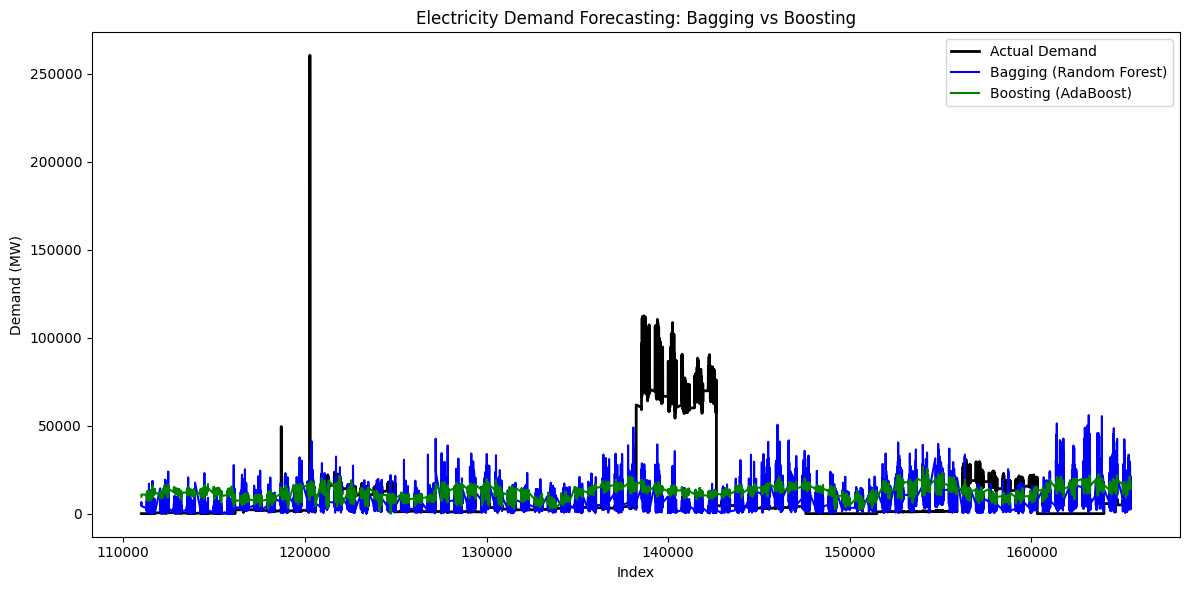

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Load and Preprocess Data ---
df = pd.read_csv('whole_merged_data.csv', low_memory=False)
df = df.iloc[:165741]
df.columns = df.columns.str.strip()

df['Data Date'] = pd.to_datetime(df['Data Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Data Date')

df['Day'] = df['Data Date'].dt.day
df['Month'] = df['Data Date'].dt.month
df['Weekday'] = df['Data Date'].dt.weekday

if 'Demand (MW)' in df.columns:
    df.rename(columns={'Demand (MW)': 'Demand'}, inplace=True)

df['Demand'] = df['Demand'].replace({',': ''}, regex=True)
df['Demand'] = pd.to_numeric(df['Demand'], errors='coerce')
df.dropna(subset=['Demand'], inplace=True)

features = ['precipIntensity', 'precipProbability', 'temperature', 'humidity',
            'pressure', 'windSpeed', 'cloudCover', 'uvIndex', 'visibility']
features += ['Day', 'Month', 'Weekday']

df['Next_Demand'] = df['Demand'].shift(-1)
df.dropna(subset=['Next_Demand'], inplace=True)

imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

X = df[features]
y = df['Next_Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 1. Bagging: Random Forest Regressor ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nBagging (Random Forest) Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_rf):.2f}")

# --- 2. Boosting: AdaBoost Regressor ---
adb = AdaBoostRegressor(estimator=LinearRegression(), n_estimators=100, random_state=42)
adb.fit(X_train_scaled, y_train)
y_pred_adb = adb.predict(X_test_scaled)

print("\nBoosting (AdaBoost) Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_adb):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_adb)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_adb):.2f}")

# --- Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Demand', color='black', linewidth=2)
plt.plot(y_test.index, y_pred_rf, label='Bagging (Random Forest)', color='blue')
plt.plot(y_test.index, y_pred_adb, label='Boosting (AdaBoost)', color='green')
plt.xlabel('Index')
plt.ylabel('Demand (MW)')
plt.title('Electricity Demand Forecasting: Bagging vs Boosting')
plt.legend()
plt.tight_layout()
plt.show()
